IMPORTING THE REQUIRED PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import optimizers

In [2]:
dir = 'dataset'
listdir = os.listdir(dir)

print(listdir)
print("The number of dataset :", len(listdir))

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']
The number of dataset : 8


In [3]:
num = ['B05', 'B07', 'B18', 'B33', 'B34', 'B46', 'B47', 'B48']
for i in range(len(listdir)):
    vector = np.zeros((1,3))
    path = os.path.join(os.getcwd(), 'dataset/', num[i] + '_discharge_soh.csv')
    csv = pd.read_csv(path)
    df = pd.DataFrame(csv)
    
    vec = df[['cycle', 'capacity', 'SOH']]
    
    globals()['data_{}'.format(num[i])] = vec

In [4]:
data = pd.read_csv('dataset/B05_discharge_soh.csv')
df = pd.DataFrame(data)
df

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,capacity,cycle,SOH
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487,1,0.928244
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487,1,0.928244
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487,1,0.928244
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487,1,0.928244
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487,1,0.928244
...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.662540
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.662540
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.662540
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.662540


In [5]:
data_B05

,cycle,capacity,SOH
0,1,1.856487,0.928244
1,1,1.856487,0.928244
2,1,1.856487,0.928244
3,1,1.856487,0.928244
4,1,1.856487,0.928244
...,...,...,...
50280,168,1.325079,0.662540
50281,168,1.325079,0.662540
50282,168,1.325079,0.662540
50283,168,1.325079,0.662540


In [6]:
for i in range(len(listdir)):
    print("Shape of data :", np.shape(globals()['data_{}'.format(num[i])]))

Shape of data : (50285, 3)
Shape of data : (50285, 3)
Shape of data : (34866, 3)
Shape of data : (42200, 3)
Shape of data : (45909, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)
Shape of data : (23478, 3)


In [7]:
print(listdir)
dataset = data_B48["SOH"]
cycle = data_B48['cycle']

dataset = np.array(dataset)
dataset = dataset.reshape((len(dataset),1))
dataset.shape

['B05_discharge_soh.csv', 'B07_discharge_soh.csv', 'B18_discharge_soh.csv', 'B33_discharge_soh.csv', 'B34_discharge_soh.csv', 'B46_discharge_soh.csv', 'B47_discharge_soh.csv', 'B48_discharge_soh.csv']


(23478, 1)

CREATING TESTS AND TRAIN DATASETS

In [8]:
train_size = int(len(dataset) * 0.8)
# train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

18782 4696


In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [10]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

18777
4691


In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX)
print(testX.shape)

[[[0.75384667 0.75384667 0.75384667 0.75384667 0.75384667]]

 [[0.75384667 0.75384667 0.75384667 0.75384667 0.75384667]]

 [[0.75384667 0.75384667 0.75384667 0.75384667 0.75384667]]

 ...

 [[0.63294169 0.63294169 0.63294169 0.63294169 0.63294169]]

 [[0.63294169 0.63294169 0.63294169 0.63294169 0.63294169]]

 [[0.63294169 0.63294169 0.63294169 0.63294169 0.63294169]]]
(4691, 1, 5)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Ensure trainX and testX have the shape (samples, time steps, features)
print(trainX.shape)  # Should be (samples, 1, features)
print(testX.shape)   # Should be (samples, 1, features)

# CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=1))  # Note: pool_size=1 since we have only 1 time step
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

history = model.fit(trainX, trainY, epochs=100, batch_size=20, validation_data=(testX, testY), verbose=1, shuffle=False)


(18777, 1, 5)
(4691, 1, 5)
Epoch 1/100


c:\Users\sidar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0212 - val_loss: 0.0062
Epoch 2/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 3/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064 - val_loss: 8.2729e-04
Epoch 4/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 5/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0051 - val_loss: 0.0177
Epoch 6/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 7/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 8/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0043 - val_loss: 0.0087
Epoch 9/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 10/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 11/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 12/100
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

In [13]:
# save model architecture
# save model architecture
# model_json = model.to_json()
# open('50%/model/B18_model.json', 'w').write(model_json)

# # save model's learned weights
# model.save_weights('50%/model/B18_weights.weights.h5', overwrite=True)

In [14]:
# from keras.models import model_from_json 

# json_file = open("50%/model/B07_model.json", "r")
# loaded_model_json = json_file.read() 
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
 
# # model weight load 
# loaded_model.load_weights("50%/model/B07_weights.weights.h5")
# print("Loaded model from disk")

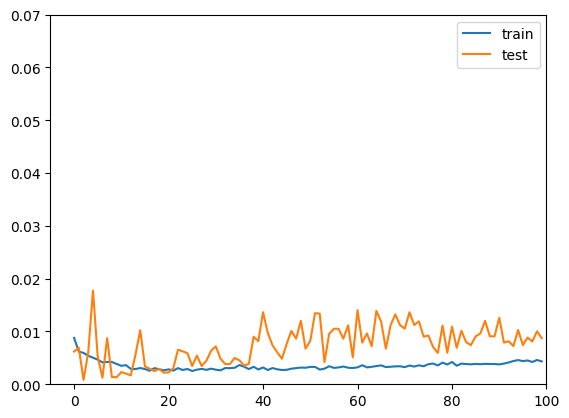

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.axis([-5, 100, 0, 0.07])
plt.legend() 
plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
587/587 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step


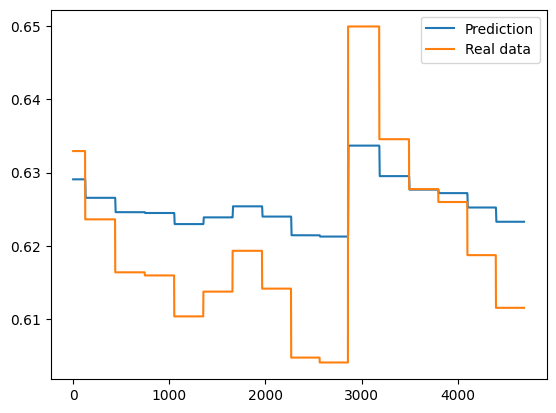

In [16]:
yhat = model.predict(testX)
tyhat = model.predict(trainX)
plt.plot(yhat, label='Prediction')
plt.plot(testY, label='Real data')
plt.legend()
plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
587/587 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step


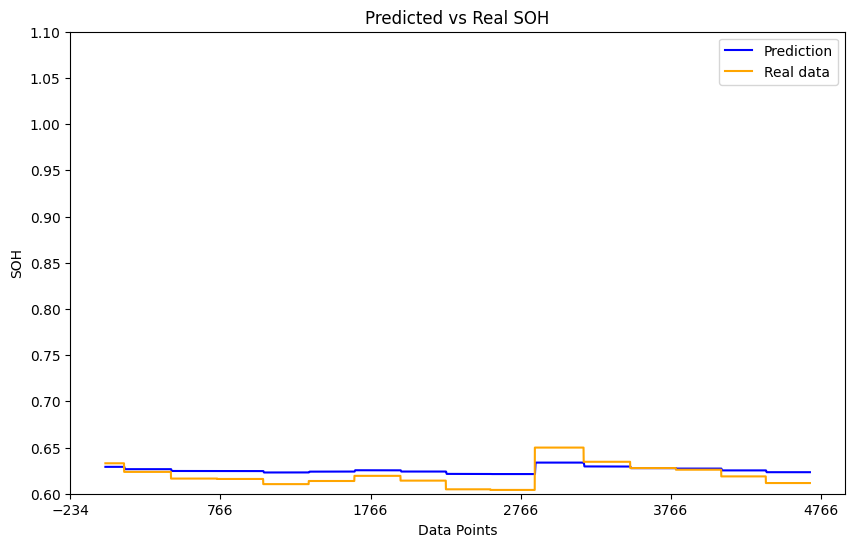

In [17]:
import numpy as np

# Predict using the model
yhat = model.predict(testX)
tyhat = model.predict(trainX)

# Plot predictions vs real data
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size for better readability
plt.plot(yhat, label='Prediction', color='blue')
plt.plot(testY, label='Real data', color='orange')
plt.legend()

# Set y-axis ticks at intervals of 0.05, ensuring 10 intervals
y_min = min(min(yhat), min(testY))  # Minimum value from predictions and actual data
y_max = max(max(yhat), max(testY))  # Maximum value from predictions and actual data

# Adjust limits to ensure at least 10 intervals
y_min = np.floor(y_min / 0.05) * 0.05
y_max = np.ceil(y_max / 0.05) * 0.05
if (y_max - y_min) < 0.5:  # Ensure at least 10 intervals of 0.05
    y_max = y_min + 0.5
plt.ylim(y_min, y_max)

# Set y-axis ticks at intervals of 0.05
plt.yticks(np.arange(y_min, y_max + 0.05, 0.05))

# Set x-axis ticks at intervals of 1000
x_min, x_max = plt.xlim()  # Get current x-axis limits
plt.xticks(np.arange(x_min, x_max, 1000))

# Add labels and title
plt.xlabel('Data Points')
plt.ylabel('SOH')
plt.title('Predicted vs Real SOH')

plt.show()


In [18]:
print("Shape of train data :", trainX.shape)
print("Shape of prediction :", yhat.shape)
print("Shape of real data :", testY.shape)

Shape of train data : (18777, 1, 5)
Shape of prediction : (4691, 1)
Shape of real data : (4691,)


In [19]:
rmse = math.sqrt(mean_squared_error(testY, yhat))
mae = mean_absolute_error(testY, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.010
Test MAE: 0.009


In [20]:
from sklearn.metrics import r2_score
r2 = r2_score(testY, yhat)
print('Test R² Score: %.3f' % r2)


Test R² Score: 0.234


In [21]:
mape = np.mean(np.abs((testY - yhat) / testY)) * 100
print('Test MAPE: %.3f' % mape)


Test MAPE: 1.799


In [22]:
from sklearn.metrics import median_absolute_error
med_ae = median_absolute_error(testY, yhat)
print('Test Median Absolute Error: %.3f' % med_ae)


Test Median Absolute Error: 0.009
